# Stærðfræði og reiknifræði – Tímadæmi 10 – MNIST og solve.

In [5]:
#BYRJA -- Keyrið til að frumstilla
import numpy as np, numpy.random as npr
import scipy.stats as stat, statsmodels.api as sm, scipy.linalg as la
import matplotlib.pyplot as plt, matplotlib as mpl, struct, gzip
from scipy.cluster.vq import kmeans, whiten, vq
%matplotlib inline
plt.rc('axes', axisbelow=True);
# disp(x,y...) skrifar x,y... með 3 aukastöfum
def disp(*args): print(*(f'{a:.3f}' if isinstance(a,float) else a for a in args))
np.set_printoptions(precision=4, floatmode='fixed', suppress=True, linewidth=150)
mpl.rc('image',cmap='binary')

Þessi dæmatími er tvískiptur, annarsvegar vinnum við aðeins áfram með MNIST gagnasafnið og sjáum hvernig hægt er að ná betri árangri við að þekkja tölustafina, og hinsvegar kynnumst við aðeins margföldun fylkis og vigurs með `@` og lausn jöfnuhneppa með `scipy.linalg.solve`.

## A. Inngangur. upprifjun á Tímadæmum 9
Tímadæmi 9 snerust um MNIST, gagnasafn 70000 mynda af handskrifuðum tölustöfum, hver um sig í 28 x 28  fylki af gráskalatónum. Safnið skiptist í 60000 mynda þjálfunarhluta og 10000 mynda prófunarhluta. Næstu reitir, sem byggja á lausn T9, rifja þetta upp. Skoðið aðeins hvað þeir gera og keyrið þá.

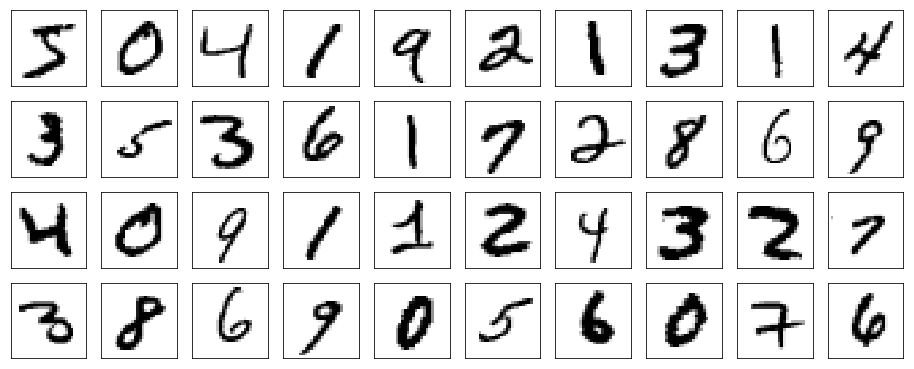

In [10]:
def lesa_igz(skráarnafn):
    "Skilar fylki með gögnum úr skrá með idx-gzip-sniði"
    with gzip.open(skráarnafn, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
def sýnamyndir(list, n=10, width=16):
    """Birtir myndir list[0], list[1]... í samsettri mynd, n í hverri línu"""
    l = len(list)
    m = (l-1)//n + 1
    plt.figure(figsize=(width, width*m/n))
    if np.ndim(list) == 2:
        list = np.reshape(list, (-1,28,28))
    for i in range(l):
        plt.subplot(m, n, i+1)
        plt.imshow(list[i])
        plt.xticks([]); plt.yticks([])    

# Gagnasafn lesið inn
train = lesa_igz('mnisttrain.gz')
label = lesa_igz('mnisttrainlabel.gz')
test = lesa_igz('mnisttest.gz')
tstlbl = lesa_igz('mnisttestlabel.gz')

# Fyrstu 50 þjálfunarmyndir teiknaðar
sýnamyndir(train[0:40])

Reiturinn hér á eftir reiknar og teiknar meðaltölustafina og undirbýr flokkun með því að breyta hverri þjálfunarmynd í vigur og sömuleiðis öllum meðaltalsmyndunum.

(60000, 28, 28)
(60000, 784)


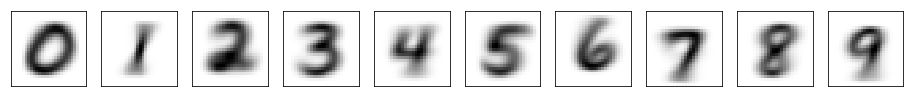

In [11]:
M = [np.mean(train[label==i], 0) for i in range(10)]
sýnamyndir(M)

def vectorize(x):
    """Breytir hverri mynd í x í float vigur
    Ef shape(x) er (k,28,28) er skilað fylki með k línum og 784 dálkum (28*28=784)"""
    return np.reshape(x, (len(x),28*28)).astype(float)

X = vectorize(train)
cb = vectorize(M)

disp(np.shape(train))
disp(np.shape(X))

Hér er svo reitur sem notar hugmyndir úr k-means til að flokka myndirnar. Fyrir hverja mynd er fallið `vq` notað til að finna næsta meðaltölustaf. Í ljós kemur að villutíðnin er um 19%. Reiturinn sýnir svo réttan flokk og spá fyrir fyrstu 20 myndirnar (fimma nr. 12 og nía nr. 20 flokkast sem báðar sem ás (1)) og reiturinn endar á að birta 30 fyrstu rangt flokkuðu myndirnar.

hlutfall rangt = 19.2%
rétt = [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
spáð = [5 0 4 1 9 2 1 3 1 4 3 1 3 6 1 7 2 8 6 1]
Rangt flokkaðar myndir:


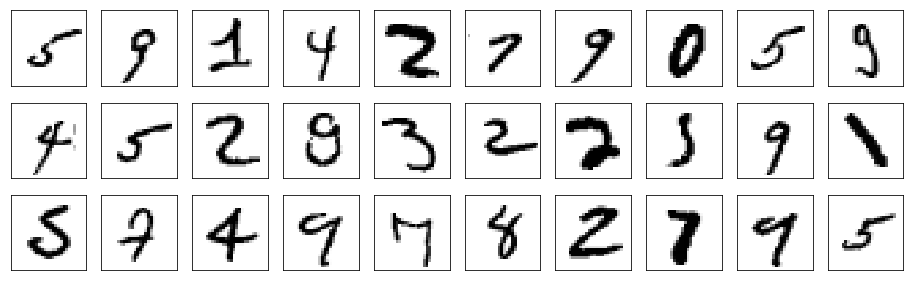

In [12]:
(spáð,_) = vq(X, cb)
rangar = train[spáð != label]
hlutf = 100*len(rangar)/len(train)
print(f'hlutfall rangt = {hlutf:.1f}%')
disp('rétt =', label[0:20])
disp('spáð =', spáð[0:20])
disp('Rangt flokkaðar myndir:')
sýnamyndir(rangar[0:30])

Að lokum er hér reitur sem flokkar fjarkana með *k-means* í 20 flokka og teiknar fulltrúana sem finnast. Til að k-means sé ekki of lengi að keyra er byrjað á að fækka fjörkunum úr ca. 6000 í 2000.

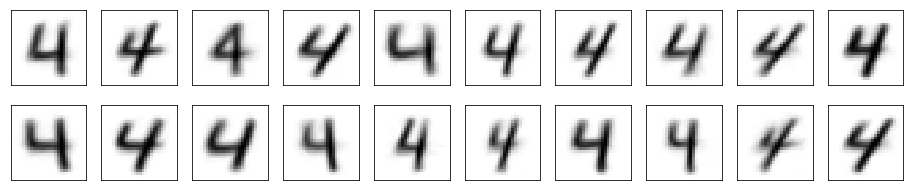

In [20]:
npr.seed(13)
X4 = X[label==4]
X4 = X4[:2000]
(cb4,_) = kmeans(X4, 20)
sýnamyndir(cb4)

## B. Undirflokkar talna
1. Aftasti reiturinn í A-lið fann 20 undirflokka af fjörkum. Búið til fall `undirflokkar` úr skipunum hans með einn stika, tölustafinn sem á að flokka í undirflokka. Prófið það á nokkrar tölur, m.a. 1, 7 og 9.

array([[0.0000, 0.0000, 0.0000, ..., 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, ..., 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, ..., 0.0000, 0.0000, 0.0000],
       ...,
       [0.0000, 0.0000, 0.0000, ..., 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, ..., 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, ..., 0.0000, 0.0000, 0.0000]])

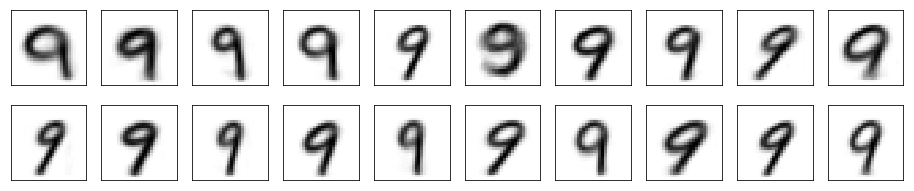

In [28]:
#B1
def undirflokkar(tala):
    npr.seed(13)
    X4 = X[label==tala]
    X4 = X4[:2000]
    (cb,_) = kmeans(X4, 20)
    sýnamyndir(cb)
    return cb

undirflokkar(9)

2. Hér er reiknirit til að flokka allar 10 tölurnar í 20 undirflokka og búa til *kóðabók* með öllum 200 flokkunum sem út úr því koma. Þýðið það í Python:

        cb200 := fylki með 0 línum og 28 x 28 dálkum
        fyrir i=0,...,9:
            skrifa 'undirflokkar fyrir ', i
            uf := undirflokkar(i)
            setjum uf neðst í cb200
Til að bæta uf neðan á cb200 má nota `np.r_[cb200, uf]`.            

(0, 784)
geri fyrir undirflokk 0
(20, 784)
geri fyrir undirflokk 1
(40, 784)
geri fyrir undirflokk 2
(60, 784)
geri fyrir undirflokk 3
(80, 784)
geri fyrir undirflokk 4
(100, 784)
geri fyrir undirflokk 5
(120, 784)
geri fyrir undirflokk 6
(140, 784)
geri fyrir undirflokk 7
(160, 784)
geri fyrir undirflokk 8
(180, 784)
geri fyrir undirflokk 9
(200, 784)


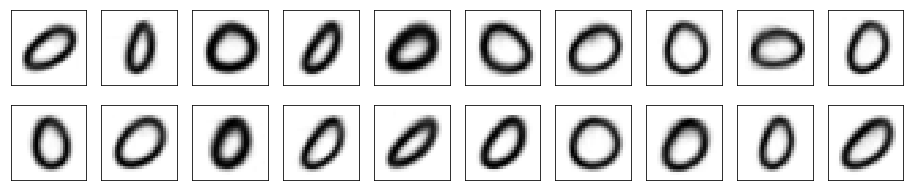

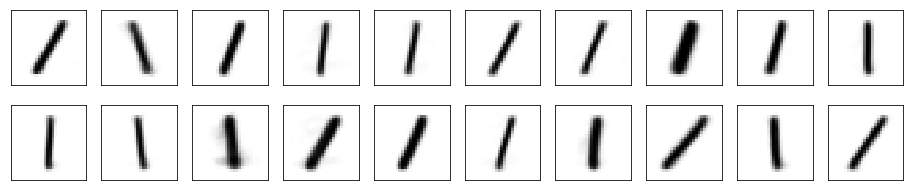

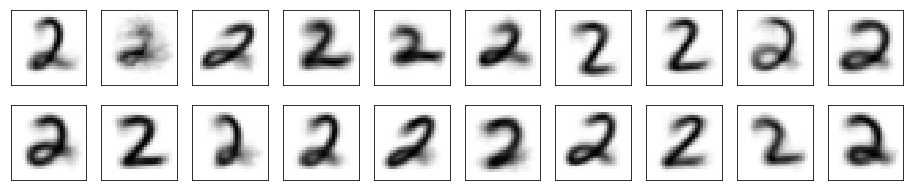

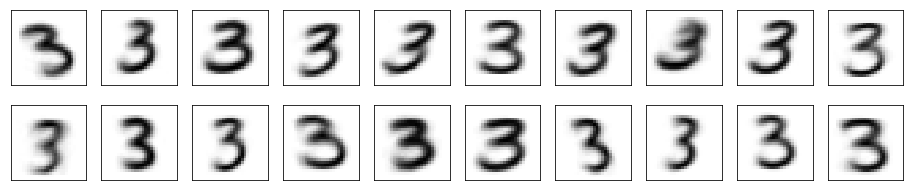

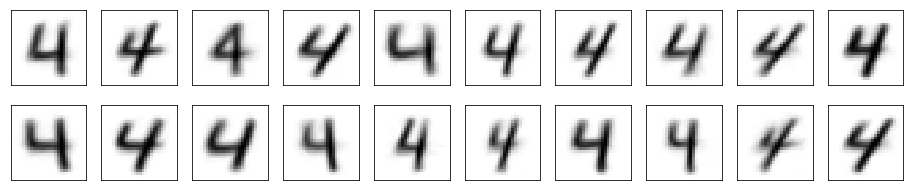

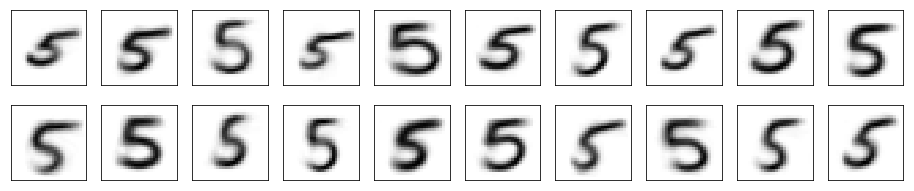

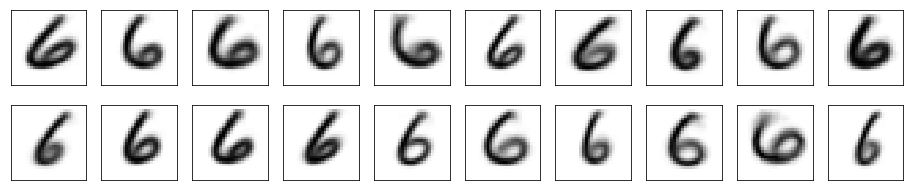

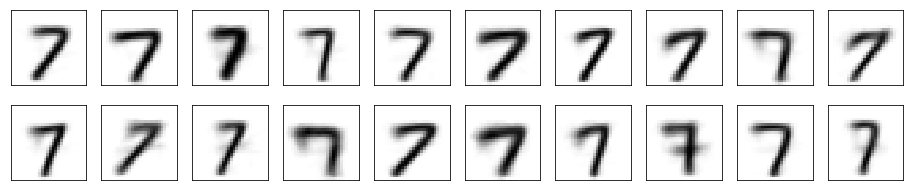

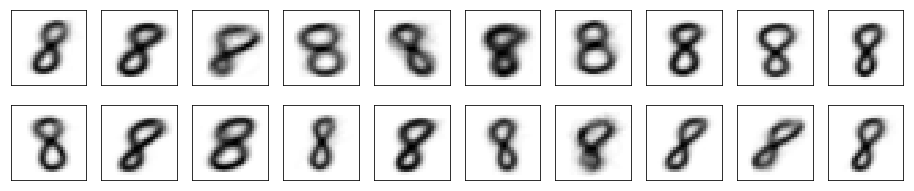

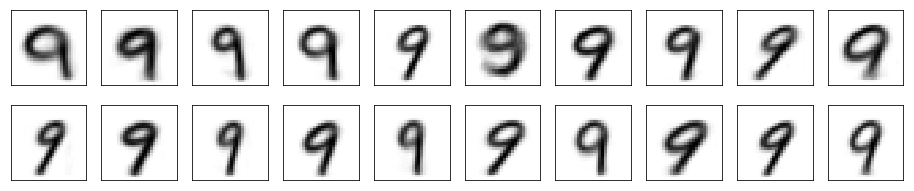

In [29]:
#B2
cb200 = np.zeros((0, 28*28))
disp(np.shape(cb200))
for i in range(10):
    disp('geri fyrir undirflokk', i)
    uf = undirflokkar(i)
    cb200 = np.r_[cb200, uf]
    disp(np.shape(cb200))

3. Notið nú *kóðabókina* cb200 úr lið B2 til að flokka allar myndirnar í þjálfunarmenginu. Ef við notum `vq` til þess fást flokkar á bilinu 0–199, flokkar 0-19 eru núllin, flokkar 20-39 eru ásarnir o.s.frv., svo það þarf að deila með 20 í flokkinn sem kemur úr `vq`, t.d. með `spáð = spáð//20`. Hvert verður hlutfall rangt flokkaðra mynda nú?

In [35]:
#B3
(spa, _) = vq(X, cb200)
spa = spa // 20
rangar = train[spa != label]
hlutf = 100*len(rangar)/len(train)
print(f'Hlutfall: {hlutf:.2f}%')

Hlutfall: 6.29%


## C. Margföldun fylkis og vigurs.
Hægt er að margfalda saman $m\times n$ fylki $A$  og $n$-vigur $x$, og útkoman er $m$-vigur þar sem stak nr. $i$ er innfeldið af $i$-tu línu $A$ og $x$. Í Python má reikna margfeldi fylkis og vigurs með virkjanum `@` (sem reiknar líka innfeldi). Ef

$$A = \pmatrix{1 & 2\\3 & 4} \text{ og }x = \pmatrix{5\\6}$$

þá er

$$A x = \pmatrix{(1, 2)\cdot(5,6)\\(3,4)\cdot(5,6)} = 
\pmatrix{1\cdot 5 + 2\cdot 6\\3\cdot 5 + 4\cdot 6} = \pmatrix{17\\39}$$

Búið til $A$ og $x$ í Python og margfaldið þau saman.

In [38]:
##C
A = np.array([[1,2],[3,4]])
x = np.array([5,6])
print( A @ x)

[17 39]


## D Lausn jöfnuhneppa með SciPy
Til að leysa $n$ línuleger jöfnur með $n$ óþekktum með SciPy má nota fallið `la.solve` (þar sem `scipy.linalg` er flutt inn sem `la`). Til að leysa jöfnurnar úr æfingu F10.1:

$$\begin{align}
y + 2z &= 8\\
3x - 4y + 2z &= 1\\
-3x + 5y + z &= 10
\end{align}$$

er búið til fylki og vigur:

$$A = \pmatrix{0 & 1 & 2\\3 & -4 & 2\\-3 & 5 & 1}, b = \pmatrix{8\\1\\10}$$

og svo má leysa jöfnuna

$$A \pmatrix{x\\y\\z} = b$$

með `xyz = la.solve(A, b)`. Prófið það (lausnin sem ætti að koma er $x=1, y=2, z=3$).

In [93]:
##D